In [1]:
import numpy as np
import pandas as pd

## Reading the extracted csv file

In [2]:
df = pd.read_csv('fer2013/fer2013.csv')

## Columns

In [3]:
df.columns

Index(['emotion', 'pixels', 'Usage'], dtype='object')

### Dictionary of classes with their numeric representation

In [14]:
dict = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

### Grouping using Usage column i.e, PrivateTest, PublicTest, Training data

In [7]:
grp = df.groupby('Usage')

In [8]:
grp.groups

{'PrivateTest': Int64Index([32298, 32299, 32300, 32301, 32302, 32303, 32304, 32305, 32306,
             32307,
             ...
             35877, 35878, 35879, 35880, 35881, 35882, 35883, 35884, 35885,
             35886],
            dtype='int64', length=3589),
 'PublicTest': Int64Index([28709, 28710, 28711, 28712, 28713, 28714, 28715, 28716, 28717,
             28718,
             ...
             32288, 32289, 32290, 32291, 32292, 32293, 32294, 32295, 32296,
             32297],
            dtype='int64', length=3589),
 'Training': Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                 9,
             ...
             28699, 28700, 28701, 28702, 28703, 28704, 28705, 28706, 28707,
             28708],
            dtype='int64', length=28709)}

In [9]:
test=grp.get_group('PrivateTest')

In [10]:
val=grp.get_group('PublicTest')

In [11]:
train = grp.get_group('Training')

### Visualizing the class distribution

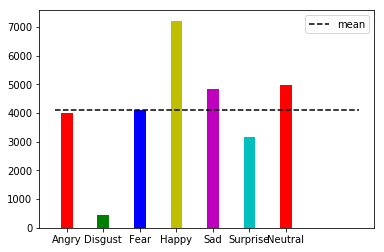

In [15]:
# distribution classes in training data
p=train.groupby('emotion')['emotion'].count()
plt.xticks(np.arange(1,len(p)*3,3),dict.values())
plt.bar(np.arange(1,len(p)*3,3),p,color='rgbymc',align='center', width=0.95)
plt.plot([0,25],[p.mean(),p.mean()],'k--',label='mean')
plt.legend()

Can see the Disgust images are comparatively quite low 

# Pre-processing 

In [16]:
test = test.reset_index()
test = test.drop(['Usage','index'],axis=1)

In [17]:
val = val.reset_index()
val = val.drop(['Usage','index'],axis=1)
train = train.reset_index()
train = train.drop(['Usage','index'],axis=1)

Randomly shuffling

In [18]:
train = train.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [19]:
p= []
for n,i in enumerate(test['pixels']):
    temp = list(map(int, i.split()))
    p.append(np.array(temp))
x_test = np.array(p) 

In [20]:
p= []
for n,i in enumerate(train['pixels']):
    temp = list(map(int, i.split()))
    p.append(np.array(temp))
x_train = np.array(p) 
p= []
for n,i in enumerate(val['pixels']):
    temp = list(map(int, i.split()))
    p.append(np.array(temp))
x_val = np.array(p) 

In [21]:
y_test, y_val, y_train = test['emotion'].values, val['emotion'].values, train['emotion'].values

Visualizing some images

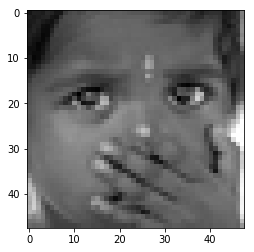

Surprise


In [25]:
#set accordingly
index = 457
plt.imshow(x_train[457].reshape(48,48),cmap='gray')
plt.show()
print(dict[y_train[457]])

 * This data augmentation did not helped me but one can test by uncommenting below lines
 * Also due to low quality of images zooming in, shifting scene and all other preprocessing step become difficult to implement 

In [26]:
# # Finding all indexes with class label 1 i.e, disgust 
# ind = []
# for n, i in enumerate(y_train):
#     if i == 1:
#         ind.append(n)

# x_temp = []
# y_temp = []
# for i in ind:
#     temp = x_train[i]
#     t= cv2.flip(temp.reshape(48,48),1)
#     x_temp.append(t.reshape(48*48))
#     y_temp.append(y_train[i])
    
# # Appending flipped images    
# x_train = np.vstack((x_train,np.array(x_temp)))
# y_train = np.hstack((y_train,np.array(y_temp)))


In [27]:
def batch_generator(bs,x,y=None,test=False):
    for i in range(0,len(x),bs):
        if test:
            yield x[i:i+bs]
        else:
            yield x[i:i+bs], y[i:i+bs]

In [28]:
import tensorflow as tf

In [29]:
# normalizing the data
x_train = ((x_train/255.0) - 0.5)*2
x_val = ((x_val/255.0) - 0.5)*2
x_test = ((x_test/255.0) - 0.5)*2

## Play with the hyperparametters

In [30]:
classes = 7
epochs = 230
bs = 128

## Model architecture

In [31]:
keep_prob = tf.placeholder(tf.float32,name='keep_prob')
tf_x =  tf.placeholder(dtype= tf.float32,shape = [None, 48,48,1],name='tf_x')
tf_y = tf.placeholder(dtype=tf.int32,shape=[None,],name='tf_y')

# layer 1
conv1 = tf.layers.conv2d(name='conv1',inputs = tf_x,filters = 64,kernel_size= (5,5),padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=0.1))
bn1 = tf.layers.batch_normalization(name='bn1',inputs = conv1)
bn1_ = tf.nn.relu(bn1)
pool1 = tf.layers.max_pooling2d(name='pool1',inputs=bn1_, pool_size=(2,2), strides=2)

#layer 2 
conv2 = tf.layers.conv2d(name='conv2',inputs = pool1,filters = 128 ,kernel_size= (3,3),padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=0.1))
bn2 = tf.layers.batch_normalization(name='bn2',inputs = conv2)
bn2_ = tf.nn.relu(bn2)
pool2 = tf.layers.max_pooling2d(name='pool2',inputs=bn2_, pool_size=[2, 2], strides=2)

# layer 3 
conv3 = tf.layers.conv2d(name='conv3',inputs = pool2,filters = 512 ,kernel_size= (3,3),padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=0.1))
bn3 = tf.layers.batch_normalization(name='bn3',inputs = conv3)
bn3_ = tf.nn.relu(bn3)
pool3 = tf.layers.max_pooling2d(name='pool3',inputs=bn3_, pool_size=[2, 2], strides=2)

#flattening
pool3_flat = tf.reshape(pool3, [-1,6*6*512],name='pool3_flat')

# fc layer 1 
dense1 = tf.layers.dense(inputs=pool3_flat, units=256, activation=tf.nn.relu,kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),name='dense1')
dense1_ = tf.nn.dropout(dense1, keep_prob)

# fc layer 2
dense2 = tf.layers.dense(inputs=dense1_, units=512, activation=tf.nn.relu,kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),name='dense2')
dense2_ = tf.nn.dropout(dense2, keep_prob)

logits = tf.layers.dense(inputs=dense2_, units=classes,activation=tf.nn.sigmoid,name='logits')
y_hot = tf.one_hot(indices=tf_y,depth=classes,dtype = tf.int32,name='y_hot')
loss = tf.losses.softmax_cross_entropy(y_hot, logits=logits)
optimizer  = tf.train.AdamOptimizer(1e-4).minimize(loss)
predict = tf.argmax(logits, 1)


In [32]:
cp = tf.equal(predict,tf.argmax(y_hot, 1))
accuracy = tf.reduce_mean(tf.cast(cp, tf.float32))

## Training

In [33]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ##can use below line to retrain from previous checkpoint
   #saver.restore(sess,tf.train.latest_checkpoint('./model/'))
    for i in range(epochs):
        losses = []
        for batch_x, batch_y in batch_generator(bs,x_train, y_train):
            batch_x = batch_x.reshape(-1,48,48,1)
            _, lossy = sess.run([optimizer, loss],feed_dict = {tf_x:batch_x,tf_y :batch_y,keep_prob:0.25})
            losses.append(lossy)
        acc = []
        for batch_x, batch_y in batch_generator(bs,x_val, y_val ):
            batch_x = batch_x.reshape(-1,48,48,1)
            acc.append(sess.run(accuracy, feed_dict={tf_x:batch_x, tf_y:batch_y,keep_prob :1.0}))
        print("Accuracy (validation)- ",sum(acc)/float(len(acc)))
        print('Loss in step {} is - {}'.format(i,np.average(losses)))
        if (i+1) % 5 == 0 :
            saver.save(sess,'model/sentiment-{}.ckpt'.format(i))

KeyboardInterrupt: 

In [38]:
# measuring training accuracies
with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('./model/'))
    acc=[]
    for batch_x, batch_y in batch_generator(bs,x_train, y_train):
        batch_x = batch_x.reshape(-1,48,48,1)
        acc.append(sess.run(accuracy, feed_dict={tf_x:batch_x, tf_y:batch_y,keep_prob :1.0}))
    print("Accuracy (train)- ",sum(acc)/float(len(acc))) 

INFO:tensorflow:Restoring parameters from ./model/sentiment-229.ckpt
Accuracy (train)-  0.9575375374158224


In [35]:
# getting the predictions
ans = []
with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('./model/'))
    acc=[]
    for batch_x, batch_y in batch_generator(bs,x_test, y_test):
        batch_x = batch_x.reshape(-1,48,48,1)
        ans.append(sess.run(predict, feed_dict={tf_x:batch_x,keep_prob :1.0}))


INFO:tensorflow:Restoring parameters from ./model/sentiment-229.ckpt


In [36]:
from sklearn.metrics import confusion_matrix
ans=np.concatenate(ans)
m=confusion_matrix(y_test,ans)

## Test accuracy

In [37]:
(ans == y_test).sum()/len(y_test)

0.6065756478127612

## Confusion matrix

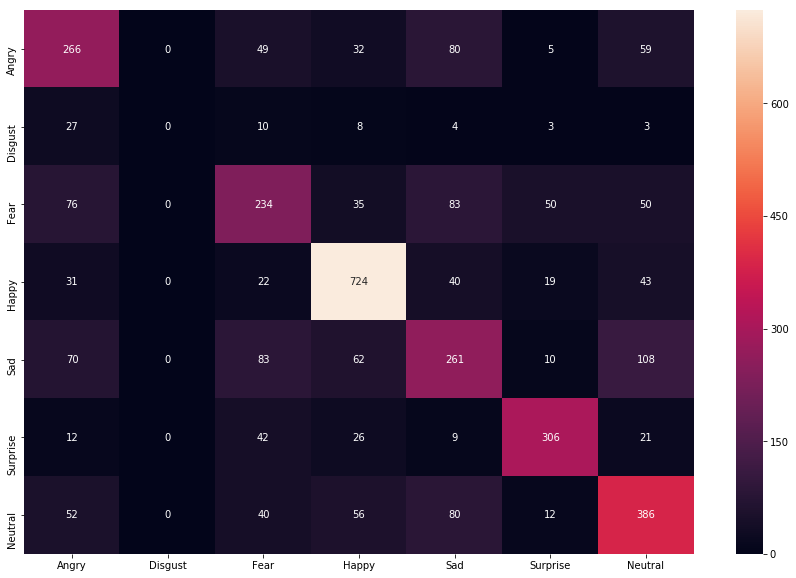

In [39]:
import seaborn as sns
df_cm = pd.DataFrame(m, dict.values(), dict.values())
plt.figure(figsize = (15,10))
sns.heatmap(df_cm, annot=True,fmt='g')

## Note- 
- Disgust class is completely ignored
- Neutral and sad is assumed to be similar
- One can get more data related to these classes and retrain the model to get more precise model